In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spectrogram-data/voice_amp_db.npy
/kaggle/input/spectrogram-data/noisy_voice_amp_db.npy


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from tensorflow.keras.models import *  # type: ignore
from tensorflow.keras.layers import *  # type: ignore
from tensorflow.keras.optimizers import *  # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler# type: ignore
from tensorflow.keras import backend  # type: ignore
from tensorflow.keras.models import Model  # type: ignore
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D  # type: ignore
import tensorflow as tf

print(tf.__version__)

# Unet network
def unet(pretrained_weights=None, input_size=(128, 128, 1)):
    size_filter_in = 16
    # kernel_init = 'glorot_uniform'
    kernel_init = 'he_normal'
    activation_layer = None
    inputs = Input(input_size)

    conv1 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in * 16, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in * 16, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in * 8, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(UpSampling2D(size=(2, 2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)

    up7 = Conv2D(size_filter_in * 4, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(UpSampling2D(size=(2, 2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)

    up8 = Conv2D(size_filter_in * 2, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(UpSampling2D(size=(2, 2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(UpSampling2D(size=(2, 2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)

    conv10 = Conv2D(1, 1, activation='tanh')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

2.16.1


In [4]:
import numpy as np
import os

# Specify the Kaggle dataset directory
dataset_dir = '/kaggle/input/spectrogram-data'

# List all files in the dataset directory
print("Files in dataset directory:", os.listdir(dataset_dir))

# Load the noisy and clean voice data
X_in = np.load(os.path.join(dataset_dir, 'noisy_voice_amp_db.npy'))
X_ou = np.load(os.path.join(dataset_dir, 'voice_amp_db.npy'))

# Perform the operation
X_ou = X_in - X_ou

# Display results
print("Shape of X_in:", X_in.shape)
print("Shape of X_ou:", X_ou.shape)


Files in dataset directory: ['voice_amp_db.npy', 'noisy_voice_amp_db.npy']
Shape of X_in: (20000, 128, 128)
Shape of X_ou: (20000, 128, 128)


In [5]:
from scipy import stats
#Check distribution
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

DescribeResult(nobs=327680000, minmax=(array([-80.]), array([3.55271368e-15])), mean=array([-43.62856799]), variance=array([276.72569126]), skewness=array([-0.19567969]), kurtosis=array([-0.36915985]))
DescribeResult(nobs=327680000, minmax=(array([-78.90244413]), array([80.])), mean=array([7.20946298]), variance=array([183.35750864]), skewness=array([1.32913254]), kurtosis=array([1.72818054]))


In [6]:
#to scale between -1 and 1
X_in = (X_in + 46)/50
X_ou = (X_ou -6 )/82

print(X_in.shape)
#Check new distribution
print(stats.describe(X_in.reshape(-1,1)))
print(stats.describe(X_ou.reshape(-1,1)))

(20000, 128, 128)
DescribeResult(nobs=327680000, minmax=(array([-0.68]), array([0.92])), mean=array([0.04742864]), variance=array([0.11069028]), skewness=array([-0.19567969]), kurtosis=array([-0.36915985]))
DescribeResult(nobs=327680000, minmax=(array([-1.03539566]), array([0.90243902])), mean=array([0.01474955]), variance=array([0.02726911]), skewness=array([1.32913254]), kurtosis=array([1.72818054]))


In [7]:
print(X_in.shape,X_ou.shape)

(20000, 128, 128) (20000, 128, 128)


In [8]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

# Assuming X_in and X_ou are already loaded
# Reshape the input and output data for training
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)


# Instantiate the model
generator_nn = unet()

# Save best models to disk during training
checkpoint = ModelCheckpoint(
    '/kaggle/working/model-{epoch:03d}-{loss:03f}-{val_loss:03f}.keras',  # Change to .keras extension
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
    mode='auto'
)


# Optionally, you can add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Print model summary
generator_nn.summary()

# Train the model
history = generator_nn.fit(
    X_train, y_train,  # Training data
    epochs=9,          # Number of epochs
    batch_size= 80,     # Batch size
    shuffle=True,      # Shuffle data
    callbacks=[checkpoint, early_stopping],  # Callbacks to save the best model and monitor overfitting
    verbose=1,         # Display progress
    validation_data=(X_test, y_test)  # Validation data
)

# After training, list files in the /kaggle/working directory to see saved models
print("Files in /kaggle/working directory:")
print(os.listdir('/kaggle/working'))

# Optionally, you can download the model from Kaggle's UI by going to the "Output" tab and clicking the model file to download it.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ leaky_re_lu_5[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[

 Total params: 1,941,093 (7.40 MB)

 Trainable params: 1,941,093 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9


I0000 00:00:1733906438.790180      71 service.cc:145] XLA service 0x7da0ac04b720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733906438.790242      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733906438.790248      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733906461.461206      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0146 - mae: 0.1246
Epoch 1: val_loss improved from inf to 0.00968, saving model to /kaggle/working/model-001-0.011019-0.009679.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 74s 203ms/step - loss: 0.0145 - mae: 0.1245 - val_loss: 0.0097 - val_mae: 0.1046
Epoch 2/9
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0088 - mae: 0.0952
Epoch 2: val_loss improved from 0.00968 to 0.00819, saving model to /kaggle/working/model-002-0.008660-0.008192.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 211ms/step - loss: 0.0088 - mae: 0.0952 - val_loss: 0.0082 - val_mae: 0.0896
Epoch 3/9
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0080 - mae: 0.0891
Epoch 3: val_loss did not improve from 0.00819
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 212ms/step - loss: 0.0080 - mae: 0.0891 - val_loss: 0.0123 - val_mae: 0.1117
Epoch 4/9
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0076 - mae: 0.0861
Epoch 4: val_loss did not improve from 0.00819
225/225 ━━━━━━━━━━━━━━━━━━

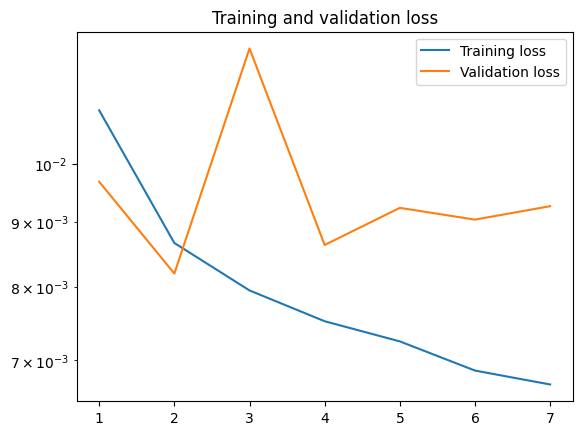

In [9]:
#Plot training and validation loss
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
#Predict and QC the output
X_pred_test = generator_nn.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step


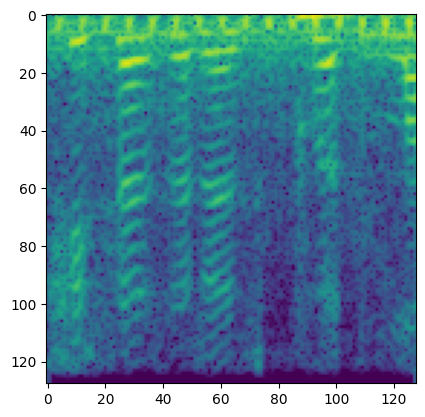

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
id = 350
plt.imshow(X_test[id,:,:,0])

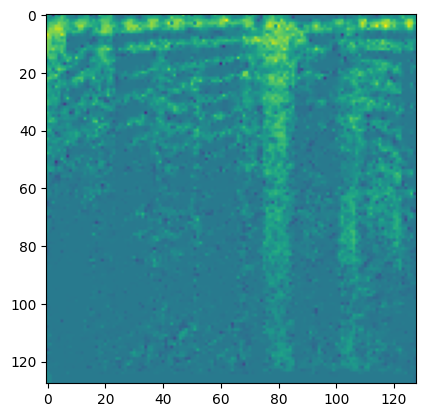

In [12]:
plt.imshow(y_test[id,:,:,0])

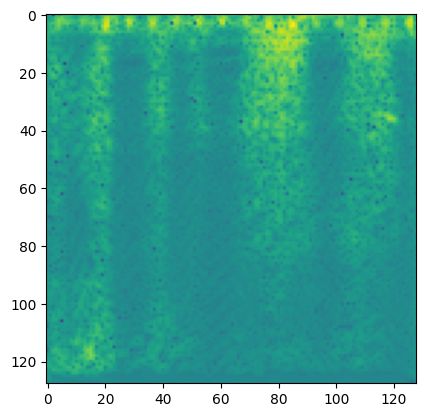

In [13]:
plt.imshow(X_pred_test[id,:,:,0])